In [1]:
# lib
# ! pip install albumentations

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import torch.nn.functional as F

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# load
class CamVidDataset(torch.utils.data.Dataset):
    """
    CamVid Dataset: read images, augmentation and preprocessing transformation
    args:
        images_dir(str): path to images folder
        masks_dir(str): path to segmentation masks folder
        class_values(list): values of classees to exract from segmentation mask
        augmentation(albumentations.Compose): data transformation pipeline(flip, scale)
        preprocessing(albumentations.Compose): data preprocessing(noralization, shape manipulation)
    """
    def __init__(self, images_dir, masks_dir):
        self.transform = A.Compose([
            A.Resize(256, 256),
            # A.HorizontalFlip(),  # x-axis
            # A.VerticalFlip(),  # y-axis
            A.Normalize(),  # normalization: ?range(0-256)
            ToTensorV2(),
        ])
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, mask_id.split('.')[0]+'_L'+'.png') for mask_id in self.ids]
        
    def __getitem__(self, i):
        # read data
        image = np.array(Image.open(self.images_fps[i]).convert('RGB'))
        mask = np.array(Image.open(self.masks_fps[i]).convert('RGB'))
        image = self.transform(image=image, mask=mask)
        return image['image'], image['mask'][:,:,0]
    
    def __len__(self):
        return len(self.ids)

x_train_dir = os.path.join('/kaggle/input/camvid/CamVid/train')
y_train_dir = os.path.join('/kaggle/input/camvid/CamVid/train_labels')
x_valid_dir = os.path.join('/kaggle/input/camvid/CamVid/val')
y_valid_dir = os.path.join('/kaggle/input/camvid/CamVid/val_labels')

train_dataset = CamVidDataset(x_train_dir, y_train_dir)
valid_dataset = CamVidDataset(x_valid_dir, y_valid_dir)

train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=5, shuffle=True)
# (org)image_size: torch.Size([8, 3, 720, 960]), mask_size: torch.Size([8, 720, 960])

In [3]:
# net
# ‘SAME’: padding = (kernel_size-stride)/2
class Encoder(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Encoder, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=in_ch, out_channels=out_ch,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, 1, 1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
        self.down = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        """
        : param x: input
        : return: out1(deep_layer),out2(next_layer)
        """
        out1 = self.layer(x)
        out2 = self.down(out1)    
        return out1, out2

    
class Decoder(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Decoder, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=in_ch, out_channels=out_ch,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, 1, 1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
        self.up = nn.Upsample(scale_factor=2, mode='bilinear')
        
    def forward(self, x, out1):
        """
        : param x: input former layer
        : param out1: shallow layer
        """
        x = self.up(x)
        out = torch.cat((x, out1), dim=1)  # concatenation
        out = self.layer(out)
        return out
    
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        channels = [64, 128, 256, 512, 1024]
        
        # contract
        self.d1 = Encoder(3, channels[0])  # 3-64-64
        self.d2 = Encoder(channels[0], channels[1])  # 64-128-128
        self.d3 = Encoder(channels[1], channels[2])  # 128-256-256
        self.d4 = Encoder(channels[2], channels[3])  # 256-512-512
        
        # neck
        self.nk = nn.Sequential(
            nn.Conv2d(in_channels=channels[3], out_channels=channels[4],
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channels[4]),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=channels[4], out_channels=channels[4],
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channels[4]),
            nn.ReLU(inplace=True),
        )  # 512-1024-1024
        
        # expansive
        self.u4 = Decoder(channels[4]+channels[3], channels[3])  # 1024-512-512
        self.u3 = Decoder(channels[3]+channels[2], channels[2])  # 512+256-256-256
        self.u2 = Decoder(channels[2]+channels[1], channels[1])  # 256+128-128-128
        self.u1 = Decoder(channels[1]+channels[0], channels[0])  # 128+64-64-64
        
        # segmentation
        self.so = nn.Sequential(
            nn.Conv2d(in_channels=channels[0], out_channels=1, kernel_size=1, stride=1, padding=0),  # 64-1
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        outd1, out = self.d1(x)
        outd2, out = self.d2(out)
        outd3, out = self.d3(out)
        outd4, out = self.d4(out)
        
        out = self.nk(out)
        
        out = self.u4(out, outd4)
        out = self.u3(out, outd3)
        out = self.u2(out, outd2)
        out = self.u1(out, outd1)
        
        out = self.so(out)
        
        return out

In [4]:
# loss
class DiceBCELoss(nn.Module):
    # without loss descend
    def __init__(self):
        super(DiceBCELoss, self).__init__()
        # BCEWithLogitsLoss: sigmoid+BCELoss
        self.bce = nn.BCELoss()
        
    def forward(self, inputs, targets, smooth=1):
        targets = torch.sigmoid(targets)
        # flatten label and prediction
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        # print(targets)
        intersection = (inputs*targets).sum()
        union = inputs.sum() + (targets.sum())
        dice_loss = 1 - ((2*intersection+smooth)/(union+smooth))
        bce_loss = self.bce(inputs, targets)
        loss = dice_loss + bce_loss
        return loss

class IoU(nn.Module):
    def __init__(self):
        super(IoU, self).__init__()
        
    def forward(self, inputs, targets, smooth=0.1, threshold=256*0.3):
        # flatten label and prediction
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        tempinputs = inputs.detach().cpu()
        temptargets = targets.detach().cpu()
        
        temptargets[np.nonzero(temptargets<threshold)] = 0.0
        temptargets[np.nonzero(temptargets>=threshold)] = 1.0
        # print(tempinputs, temptargets)
        intersection = (tempinputs*temptargets).sum()
        union = tempinputs.sum() + temptargets.sum()
        iou = (intersection+smooth)/(union-intersection+smooth)
        # print(intersection, union, iou)
        return iou

In [5]:
# train, test
def trainer(model, train_loader, valid_loader,
            criterion, optimizer, iou, epochs):
    
    loss_hist, train_hist, valid_hist = [],[],[]
    patience, best_acc, stale = 11, 0, 0
    for epoch in range(epochs):
        print('epoch{}/{}'.format(epoch+1, epochs))
        model.train()
        losses, train_iou, valid_iou = [],[],[]
        for image, mask in train_loader:
            image = image.to(device, dtype=torch.float)
            mask = mask.to(device, dtype=torch.float)
            pred = model.forward(image)
            
            trainpiou = iou(pred,mask)
            loss = criterion(pred, mask)
            
            losses.append(loss.item())
            train_iou.append(trainpiou.detach().cpu())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        model.eval()
        with torch.no_grad():
            for image, mask in valid_loader:
                image = image.to(device)
                mask = mask.to(device)
                pred = model.forward(image)
                validpiou = iou(pred, mask)
            valid_iou.append(validpiou.detach().cpu())
        
        loss_hist.append(np.mean(losses))
        train_hist.append(np.mean(train_iou))
        valid_hist.append(np.mean(valid_iou))
        print('loss:{}'.format(loss_hist[-1]))
        print('Train Accuracy:{}'.format(train_hist[-1]))
        print('Validation Accuracy:{}'.format(valid_hist[-1]))
        
        if valid_hist[-1] > best_acc:
            print(f'Best model found at epoch {epoch+1}, saving model')
            torch.save(model.state_dict(), 'segbrain_unetpp.pt')
            best_acc = valid_hist[-1]
            stale = 0
        else:
            stale += 1
            if stale > patience:
                print(f'No improvment {patience} consecutive epochs, break.')
                break
            
    return loss_hist, train_hist, valid_hist


def plot_model_hist(train_hist, valid_hist, loss_hist):
    x = np.arange(len(train_hist))
    
    fig = plt.figure(figsize=(10,6))
    plt.plot(x, train_hist, label='train_dice')
    plt.plot(x, valid_hist, label='valid_dice')
    plt.plot(x, loss_hist, label='train_loss')
    
    plt.title('unet', fontsize=15)
    plt.legend(fontsize=12)
    plt.xlabel('Epoch')
    plt.ylabel('Dice/Loss')
    
    plt.show()

epoch1/17
loss:0.28092093806009033
Train Accuracy:0.7801975607872009
Validation Accuracy:0.8077268600463867
Best model found at epoch 1, saving model
epoch2/17
loss:0.20972407407857277
Train Accuracy:0.8116388916969299
Validation Accuracy:0.8086465001106262
Best model found at epoch 2, saving model
epoch3/17
loss:0.19767891897543058
Train Accuracy:0.8169956207275391
Validation Accuracy:0.7654162645339966
epoch4/17
loss:0.18641190472486857
Train Accuracy:0.8235729336738586
Validation Accuracy:0.8219647407531738
Best model found at epoch 4, saving model
epoch5/17
loss:0.18128637788263527
Train Accuracy:0.8270736336708069
Validation Accuracy:0.8169828057289124
epoch6/17
loss:0.17859108021130432
Train Accuracy:0.829332709312439
Validation Accuracy:0.8332303762435913
Best model found at epoch 6, saving model
epoch7/17
loss:0.17653245619825414
Train Accuracy:0.8302785754203796
Validation Accuracy:0.8340592384338379
Best model found at epoch 7, saving model
epoch8/17
loss:0.1782213419273093
T

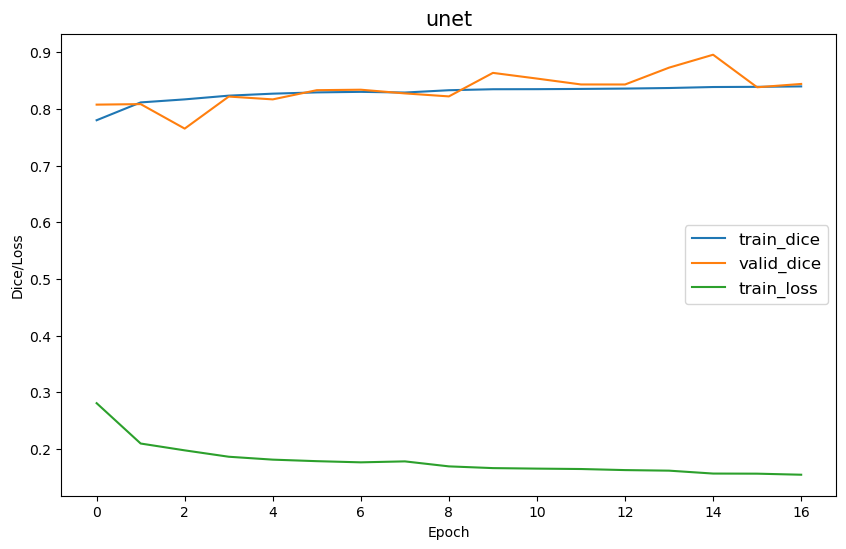

In [6]:
# run
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# torch.cuda.empty_cache()
model = UNet().to(device)
criterion = DiceBCELoss()
iou = IoU()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 17

loss_hist, train_hist, valid_hist = trainer(model, train_loader, valid_loader, criterion, optimizer, iou,epochs)
plot_model_hist(train_hist, valid_hist, loss_hist)